## Named Entity Recognition using LSTMs (with Character + Word Embeddings)

In this notebook we train a LSTM model for Named Entity Recognition on a Kaggle dataset and experiment using character embeddings.

Dataset from Kaggle: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

Source website: https://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")

In [3]:
data = data.fillna(method="ffill")

In [4]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [6]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)

In [9]:
sent = getter.get_next()

In [10]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [11]:
sentences = getter.sentences

### Prepare the data

Now we introduce dictionaries of words and tags.

In [12]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [13]:
word2idx["Obama"]

13699

In [14]:
tag2idx["B-geo"]

7

Now we map the senctences to a sequence of numbers and then pad the sequence. Note that we increased the index of the words by one to use zero as a padding value. This is done because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero.

In [15]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [16]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

Now we have to generate a dictionary for the characters we want to use and create the sequence of characters for every token. Note that we, rather arbitrary, set

to 10. We could also use longer or shorter sequences. We could even use two sequences, one with the five first characters and one with the five last characters. In general we would like to avoid padding or cutting the character sequences for words. But since keras builds on tensorflow, we have to know the lengths of our input sequences at the beginning. The solution would be to use a framework like pyTorch or maybe the tensorflow eager execution.

In [17]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

98


In [18]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [19]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [20]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [21]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

### Define the character embedding model

In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

The trick here is, to wrap the parts that should be applied to the characters in a

layer to apply the same layers to every character sequence.

In [25]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

### Train the model

Now we can compile the model as always and look at the summary.

In [26]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 10)   1000        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 20)       703620      input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [28]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 238s 6ms/step - loss: 0.5058 - acc: 0.8639 - val_loss: 0.2213 - val_acc: 0.9303
Epoch 2/10
38846/38846 [==============================] - 234s 6ms/step - loss: 0.1726 - acc: 0.9516 - val_loss: 0.1390 - val_acc: 0.9600
Epoch 3/10
38846/38846 [==============================] - 231s 6ms/step - loss: 0.1235 - acc: 0.9649 - val_loss: 0.1198 - val_acc: 0.9646 - loss: 0.1236 - acc: 0.
Epoch 4/10
38846/38846 [==============================] - 230s 6ms/step - loss: 0.1056 - acc: 0.9691 - val_loss: 0.1140 - val_acc: 0.9656
Epoch 5/10
38846/38846 [==============================] - 229s 6ms/step - loss: 0.0950 - acc: 0.9717 - val_loss: 0.1093 - val_acc: 0.9671
Epoch 6/10
38846/38846 [==============================] - 3013s 78ms/step - loss: 0.0882 - acc: 0.9731 - val_loss: 0.1056 - val_acc: 0.9685
Epoch 7/10
38846/38846 [==============================] - 248s 6ms/step - loss: 0.0828 - acc: 0.

In [29]:
hist = pd.DataFrame(history.history)

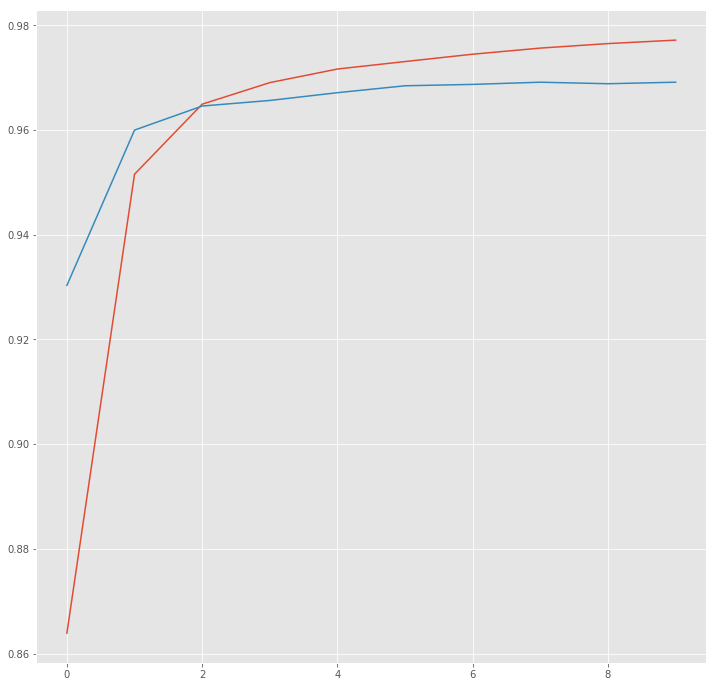

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

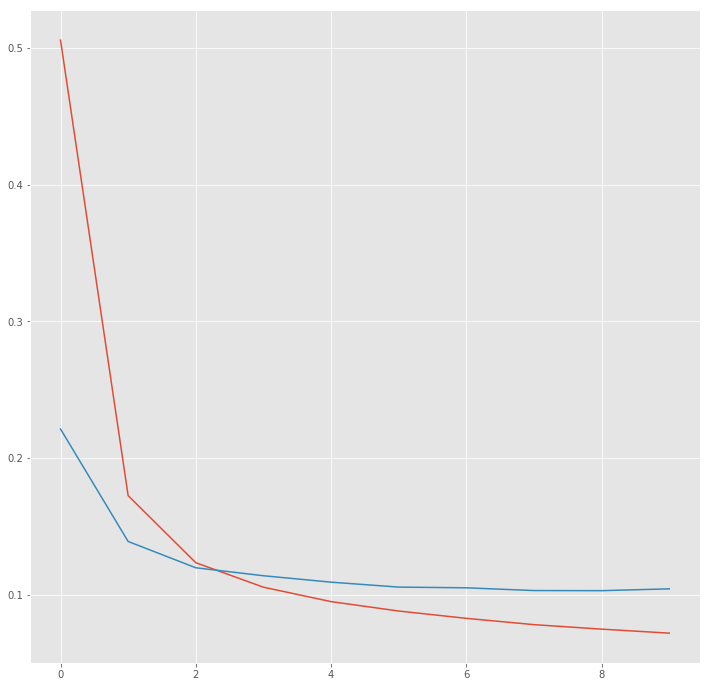

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [32]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [33]:
i = 1925
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-gpe
Foreign        : I-org O
Secretary      : B-per B-per
Jack           : I-per B-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_pred=pred, y_true=tags)
print(report)